## Comparison of NEWA and FMI wind data (Helsinki kumpula station, Jan 2018)


In [1]:
from mpl_toolkits.basemap import Basemap  # import Basemap matplotlib toolkit
import netCDF4 as nc  ## read netCDF4 data 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pickle

In [85]:
#coordinate of Helsinki kumpula weather station is 60.20307	24.96131

In [86]:
fn = 'newa-kumpula-station.nc'  # NEWA (Jan 2018) data from nearly the same coordinate as kumpula
ds = nc.Dataset(fn)

In [87]:
print(ds.__dict__['southBoundLatitude'],ds.__dict__['northBoundLatitude'])
print(ds.__dict__['westBoundLongitude'],ds.__dict__['eastBoundLongitude'])

60.196156 60.196156
24.960938 24.960938


In [88]:
ws10_NEWA = ds['WS10'][:]  # wind speed at 10m from NEWA dataset

In [89]:
# wind speed at 10m from FMI observation data 
df_fmi = pd.read_csv('kumpula_Jan_2018.csv')  
df_fmi['Wind speed (m/s)'] = df_fmi['Wind speed (m/s)'].replace('-',None).astype(float)
df_fmi['Wind speed (m/s)'].interpolate(method='linear', inplace=True)
ws10_FMI = df_fmi['Wind speed (m/s)'].values

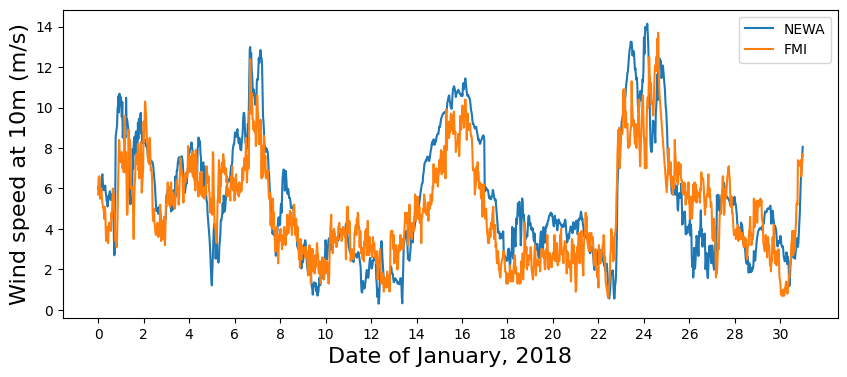

In [90]:
plt.figure(figsize=(10,4))
plt.plot(ws10_NEWA,label='NEWA')
plt.plot(ws10_FMI.reshape([-1,3]).max(axis=1),label='FMI')
plt.xticks(np.arange(0,1488,96),np.arange(0,31,2))
plt.xlabel('Date of January, 2018',fontsize=16)
plt.ylabel('Wind speed at 10m (m/s)',fontsize=16)
# plt.title('Comparison of wind speed at 10m between FMI(observations) and NEWA(simulated via WRF)')
plt.legend()
plt.show()

In [91]:
ws100 = ds['WS'][:].reshape(1488,)  # wind speed at 100m from NEWA

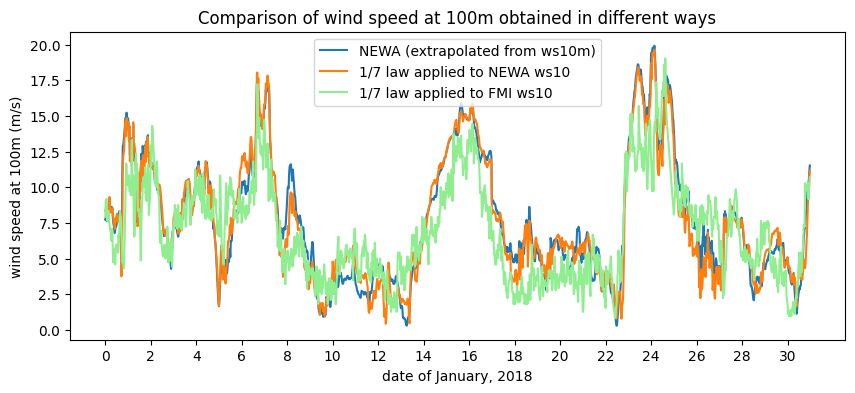

In [92]:
plt.figure(figsize=(10,4))
plt.plot(ws100,label='NEWA (extrapolated from ws10m)')
plt.plot(ws10_NEWA*(100/10)**(1/7),label='1/7 law applied to NEWA ws10')
plt.plot(ws10_FMI.reshape([-1,3]).max(axis=1)*(100/10)**(1/7),label='1/7 law applied to FMI ws10',color='lightgreen')
plt.xticks(np.arange(0,1488,96),np.arange(0,31,2))
plt.xlabel('date of January, 2018')
plt.ylabel('wind speed at 100m (m/s)')
plt.title('Comparison of wind speed at 100m obtained in different ways')
plt.legend()
plt.show()

- The extrapolation NEWA performed is similarly to Karagali et
al. (2018a, b) using 10 years of WRF model simulations from
Nuño Martinez et al. (2018) for the long-term stability correction.
- The figure above doses show 1/7 power law is basically reliable, maybe we can also stick to 1/7 law for the time being.


In [93]:
power_density = ds['PD'][:].reshape(1488,) # power density at 100m from NEWA

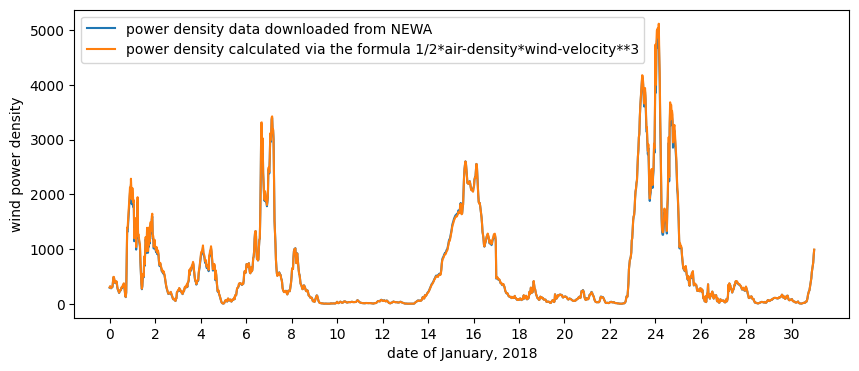

In [94]:
## NEWA used the formula ???
plt.figure(figsize=(10,4))
plt.plot(power_density,label='power density data downloaded from NEWA')
plt.plot(0.5*1.293*ws100**3,label='power density calculated via the formula 1/2*air-density*wind-velocity**3')
plt.xticks(np.arange(0,1488,96),np.arange(0,31,2))
plt.xlabel('date of January, 2018')
plt.ylabel('wind power density')
plt.legend()
plt.show()

## Comparison with ERA5 (2021)

In [3]:
#ERA5 hourly wind speed at 100m of 2021
fn = 'adaptor.mars.internal-1675753156.1999435-7330-11-dc7a0246-a189-4243-add8-30e554ed80c6.nc'
ds = nc.Dataset(fn)

In [4]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-02-07 07:00:21 GMT by grib_to_netcdf-2.25.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf.bin -S param -o /cache/data2/adaptor.mars.internal-1675753156.1999435-7330-11-dc7a0246-a189-4243-add8-30e554ed80c6.nc /cache/tmp/dc7a0246-a189-4243-add8-30e554ed80c6-adaptor.mars.internal-1675752535.4623296-7330-14-tmp.grib
    dimensions(sizes): longitude(65), latitude(61), time(8760)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 u100(time, latitude, longitude), int16 v100(time, latitude, longitude)
    groups: 


In [5]:
lats = ds['latitude'][:]
lons = ds['longitude'][:]

lons = np.tile(lons,(61,1))
lats = np.tile(lats,(65,1)).T

In [6]:
u = ds['u100'][:] 
v = ds['v100'][:] 
u.shape

(8760, 61, 65)

In [7]:
# calculate wind speed from u and v components
ws100 = np.zeros((8760,61,65))
for i in range(8760):
    ws100[i] = (u[i,:,:]**2+v[i,:,:]**2)**0.5

In [8]:
ws100.mean(axis=0).shape

(61, 65)

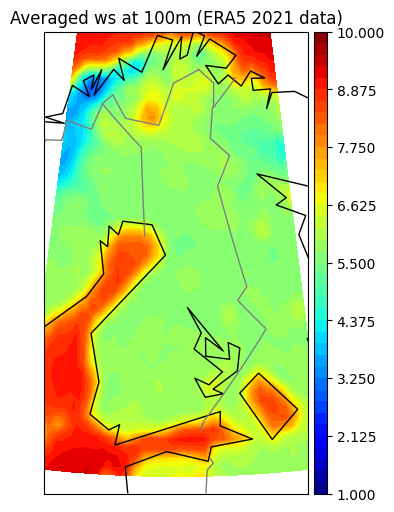

In [9]:
fig = plt.figure(figsize=(5,6))
m = Basemap(projection='lcc',lat_0=64.8238, lon_0=26.2179,width=0.8E6, height=1.4E6)
x,y = m(lons,lats)
m.drawcoastlines()
m.drawcountries(color='gray', linewidth=1)
m.drawstates(color='gray')
cs = m.contourf(x,y,ws100.mean(axis=0),np.linspace(1,10,41),cmap=plt.cm.jet)
cb = m.colorbar()
t = plt.title(f'Averaged ws at 100m (ERA5 2021 data)')

In [14]:
wind_data_dir = "../source_code/data/windspeed_stations_2021"

import os
# station coords
stations_Fin = pd.read_csv('../source_code/FMIcoords.csv')
stations_Fin['mean_ws10m'] = [0]*stations_Fin.shape[0]
for file in os.listdir(wind_data_dir):
    if not file.startswith("."):
        df = pd.read_csv(os.path.join(wind_data_dir, file))
        df['Wind speed (m/s)'] = df['Wind speed (m/s)'].replace('-',
                                                                None).astype(float)
        df['Wind speed (m/s)'].interpolate(method='linear', inplace=True)
        df['Wind speed (m/s)'] = df['Wind speed (m/s)'].apply(lambda x: np.maximum(x, 0))
        stations_Fin.loc[stations_Fin.station==file[:-4],'mean_ws10m'] = df['Wind speed (m/s)'].values.mean()

In [15]:
stations_Fin = stations_Fin[stations_Fin['mean_ws10m']!=0]

Text(0, 0.5, 'average wind speed 100m')

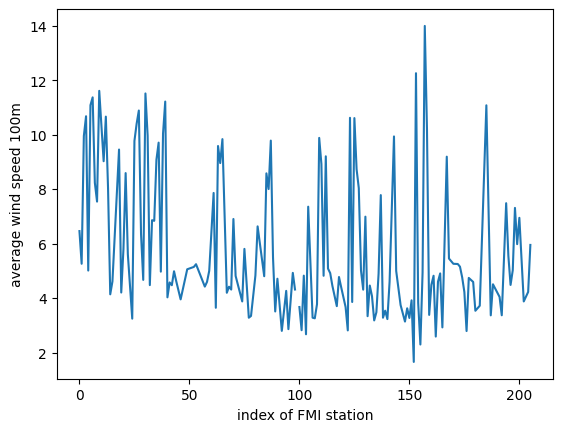

In [16]:
# average ws100m of year 2021 (FMI)', 1/7 law applied.
plt.plot(stations_Fin['mean_ws10m']*10**(1/7))
plt.xlabel('index of FMI station')
plt.ylabel('average wind speed 100m')

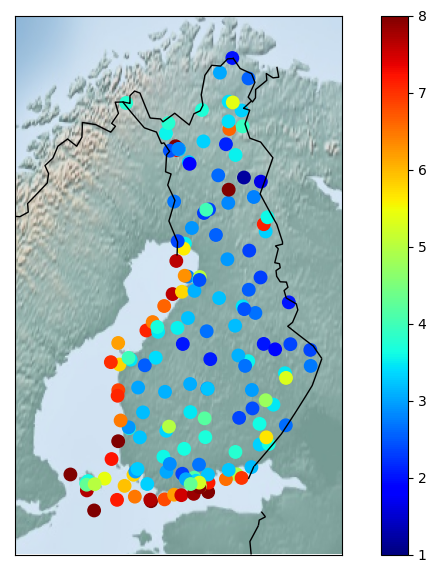

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))
m = Basemap(projection='lcc', resolution='l',
                lat_0=64.8238, lon_0=24.2179,
                width=0.85E6, height=1.4E6)
m.shadedrelief()
m.drawcountries(color='black', linewidth=1)

x, y = m(stations_Fin["longitude"].to_numpy(),
         stations_Fin["latitude"].to_numpy())  # transform coordinates
markersize = stations_Fin['mean_ws10m']
# cmap = plt.get_cmap('PiYG')

# colormesh = m.pcolormesh(x, y, markersize, vmin = 0, vmax = 10, cmap=plt.cm.jet)
# # ax.scatter(x, y, c= s=markersize*12, marker='o', facecolors='none', edgecolors='r')
sc = plt.scatter(x, y, c=markersize,cmap=plt.cm.jet, s=80, marker='o',vmin=1.000, vmax=8.000)
plt.colorbar(sc)
# plt.title('average ws10m of year 2021 (FMI)')
plt.show()

## size of circle represents the value of wind speed

Heatmap obtained by our experiment: each dot represents a FMI station, size of dot represents the workable fraction of year 2021 for a dishwasher by soley using wind energy. Wind speed was extropalated to 100m by 1/7 law, wind energy was calculated via formula (this might be changed by using the power curve of a certain turbine )
<img src="heatmap.png"  width="400" height="600">